In [2]:
import numpy as np 
import pandas as pd 
from sklearn.model_selection import train_test_split
from collections import Counter
import nltk
import pickle
import torch
from PIL import Image
from sklearn.preprocessing import OneHotEncoder
from torch.utils.data import TensorDataset, DataLoader
import pytorch_lightning as pl

**read datasets into pandas dataframe**

In [3]:
df_train = pd.read_json('/kaggle/input/vizwiz/Annotations/Annotations/train.json')
df_val = pd.read_json('/kaggle/input/vizwiz/Annotations/Annotations/val.json')
df_train.head()

,image,question,answers,answer_type,answerable
0,VizWiz_train_00000000.jpg,What's the name of this product?,"[{'answer_confidence': 'yes', 'answer': 'basil...",other,1
1,VizWiz_train_00000001.jpg,Can you tell me what is in this can please?,"[{'answer_confidence': 'yes', 'answer': 'soda'...",other,1
2,VizWiz_train_00000002.jpg,Is this enchilada sauce or is this tomatoes? ...,"[{'answer_confidence': 'yes', 'answer': 'these...",other,1
3,VizWiz_train_00000003.jpg,What is the captcha on this screenshot?,"[{'answer_confidence': 'yes', 'answer': 't36m'...",other,1
4,VizWiz_train_00000004.jpg,What is this item?,"[{'answer_confidence': 'yes', 'answer': 'solar...",other,1


**split the train data to test and train**

In [4]:
train_df, test_df = train_test_split(df_train,test_size=0.05, random_state = 42 ,stratify=df_train['answer_type'])

**function to get answer for every question from the 10 answers**

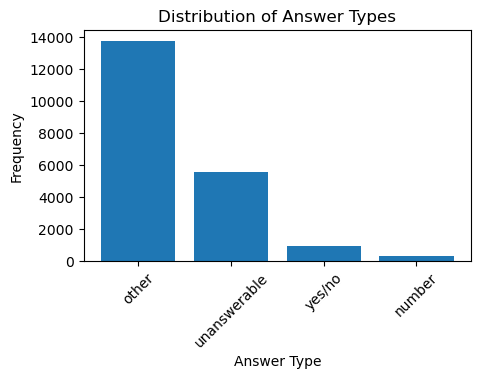

Train set size: 19496
Test set size: 1027


In [52]:
# Count the occurrences of each answer type
answer_type_counts = df_train['answer_type'].value_counts()

# Plot the histogram
plt.figure(figsize=(5, 3))
plt.bar(answer_type_counts.index, answer_type_counts.values)
plt.xlabel('Answer Type')
plt.ylabel('Frequency')
plt.title('Distribution of Answer Types')
plt.xticks(rotation=45)
plt.show()
# Verify the sizes of the train and test sets
print(f"Train set size: {len(train_df)}")
print(f"Test set size: {len(test_df)}")

In [5]:
def vocab_load(ans_list):
    ans_txt=[]
    for ans in ans_list:
        ans_txt.append(ans['answer'])
        #         print(ans['answer'])
    word_count=Counter(ans_txt)
    max_count = max(word_count.values())
    max_occ = [element for element, count in word_count.items() if count == max_count]    
    word_org=max_occ
    
    
    if len(max_occ)>1:
        word=''
        least=np.inf
        
        for k in max_occ:
            total_dst=0
            for words in ans_txt:
                total_dst=nltk.edit_distance(k,words) + total_dst
                if(total_dst<least):
                    least=total_dst
                    word=k
        word_org=[word]
   
    return word_org[0]

**generate answer for every question and the dictionary of unique values**

In [ ]:
df_train_ans = train_df['answers']

max_occ=[]
outp_feature=torch.empty((1,1024))

for i in (df_train_ans.index) :
    max_occ_val=vocab_load(df_train_ans[i])
    max_occ.append(max_occ_val)
    img_feature,question_feature=clip_encoder(0,i)
    con_feature=torch.cat((img_feature,question_feature), 1)
    outp_feature=torch.cat((outp_feature, con_feature), 0)
print(outp_feature.shape)
#     print(question_feature.shape)
print(len(max_occ))
max_occ=np.unique(max_occ)
print(len(max_occ))
outp_feature=outp_feature[1:]
print(outp_feature.shape)

**save the classes dictionary**

In [ ]:

torch.save(max_occ, 'class_occ.pt')
print(max_occ)
# Load the tensor
# loaded_tensor = torch.load('class_occ.pt')

# print(loaded_tensor)

**save train features in tensor file**

In [ ]:
# Create a PyTorch tensor
my_tensor_train = outp_feature

# Save the tensor
torch.save(my_tensor_train, 'train_feat.pt')
print(my_tensor_train)
# Load the tensor
# loaded_tensor = torch.load('train_feat.pt')

print(loaded_tensor)

**save the train indexes in tensor**

In [ ]:
train_idx = train_df.index
torch.save(train_idx, 'train_idx.pt')
print(train_idx)
# Load the tensor
# loaded_tensor = torch.load('train_idx.pt')
# print(loaded_tensor)

**save test indexes in tensor**

In [ ]:
test_idx = test_df.index
torch.save(test_idx, 'test_indx.pt')
print(test_idx)
# Load the tensor
# loaded_tensor = torch.load('test_indx.pt')
# print(loaded_tensor)

**save val indexes in torch tensor**

In [ ]:
val_indx=df_val.index
torch.save(val_indx, 'val_indx.pt') 
print(val_indx)
# Load the tensor
# loaded_tensor = torch.load('val_indx.pt')
# print(loaded_tensor)

# **load the saved indexes for test and train and val**

In [6]:
train_idx = torch.load('/kaggle/input/saved-data/train_idx.pt')

test_indx = torch.load('/kaggle/input/saved-data/test_indx.pt')

val_indx = torch.load('/kaggle/input/saved-data/val_indx.pt')

print(train_idx)
print(test_indx)
print(val_indx)

Int64Index([14709,  9566, 11322,  5267,  9281, 18827,  5396, 11843,  2593,
             8153,
            ...
            13960,  2546,  2367, 14451,  1811, 15453, 19967, 17226, 16495,
             8401],
           dtype='int64', length=19496)
Int64Index([20148,  1384, 15850, 10122, 16891,  9551,  4248, 19739, 12851,
             9060,
            ...
            17283,  1797,  6696,  1489, 12106, 10922, 17572, 16464,  1537,
             5393],
           dtype='int64', length=1027)
RangeIndex(start=0, stop=4319, step=1)


**answer for every question in train**

In [7]:
df_train_ans = df_train['answers'] 
df_train_ans = df_train_ans.iloc[train_idx]###use the pre saved indices
ans_train=[]

for i in (df_train_ans.index) :
    ans_train.append(vocab_load(df_train_ans[i]))
print(len(ans_train))


19496


**answer for every question in validation**

In [8]:
df_val_ans = df_val['answers']

df_val_ans = df_val_ans.iloc[val_indx]###use the pre saved indices

ans_val=[]
for i in (df_val_ans.index) :
    ans_val.append(vocab_load(df_val_ans[i]))
print(len(ans_val))


4319


**answer for every question in test**

In [9]:
df_test_ans = df_train['answers']
df_test_ans = df_test_ans.iloc[test_indx]###use the pre saved indices

ans_test=[]
for i in (df_test_ans.index) :
    ans_test.append(vocab_load(df_test_ans[i]))
print(len(ans_test))


1027


****

**Features for validation data**

In [108]:
outp_feature_val=torch.empty((1,1024))

for i in (df_val.index):
    img_feature,question_feature=clip_encoder(1,i)
    
    con_feature_val=torch.cat((img_feature,question_feature), 1)
    
    outp_feature_val=torch.cat((outp_feature_val, con_feature_val), 0)
    
print(outp_feature_val.shape)

outp_feature_val=outp_feature_val[1:]

print(outp_feature_val.shape)


# Create a PyTorch tensor
my_tensor_val = outp_feature_val
# Save the tensor
torch.save(my_tensor_val, 'val_feat.pt')
print(my_tensor_val)

# Load the tensor
# loaded_tensor = torch.load('val_feat.pt')

# print(loaded_tensor)

NameError: name 'clip_encoder' is not defined

**Features for test**

In [ ]:
outp_feature_tst=torch.empty((1,1024))

for i in (test_df.index):
    img_feature,question_feature=clip_encoder(0,i)
    
    con_feature_tst=torch.cat((img_feature,question_feature), 1)
    
    outp_feature_tst=torch.cat((outp_feature_tst, con_feature_tst), 0)
    
print(outp_feature_tst.shape)

outp_feature_tst=outp_feature_tst[1:]

print(outp_feature_tst.shape)


# Create a PyTorch tensor
my_tensor_test = outp_feature_tst
# Save the tensor
torch.save(my_tensor_test, 'test_feat.pt')
print(my_tensor_test)

# Load the tensor
loaded_tensor = torch.load('test_feat.pt')

print(loaded_tensor)

In [11]:
 pip install git+https://github.com/openai/CLIP.git


  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-1o1ro6cx
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-1o1ro6cx
  Resolved https://github.com/openai/CLIP.git to commit a9b1bf5920416aaeaec965c25dd9e8f98c864f16
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 2.2 MB/s eta 0:00:00
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369410 sha256=f833e5d03907e15bf1950acd6354026fcfbbe1bc6c6cad1507fbee23ba93056c
  Stored in directory: /tmp/pip-ephem-wheel-cache-vk68czjo/wheels/da/2b/4c/d6691fa9597aac8bb85d2ac13b112deb897d5b50f5ad9a37e4
Successfully built clip
Note: you may need to restart the kernel to use updated packages.


In [12]:
import clip

clip.available_models()

['RN50',
 'RN101',
 'RN50x4',
 'RN50x16',
 'RN50x64',
 'ViT-B/32',
 'ViT-B/16',
 'ViT-L/14',
 'ViT-L/14@336px']

In [29]:
# device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model_clip, preprocess = clip.load("ViT-B/32")
input_resolution = model_clip.visual.input_resolution
context_length = model_clip.context_length
vocab_size = model_clip.vocab_size

print("Model parameters:", f"{np.sum([int(np.prod(p.shape)) for p in model_clip.parameters()]):,}")
print("Input resolution:", input_resolution)
print("Context length:", context_length)
print("Vocab size:", vocab_size)

Model parameters: 151,277,313
Input resolution: 224
Context length: 77
Vocab size: 49408


In [30]:
from PIL import Image

def clip_encoder(value,index):
#     print(index)
    if value==0:
        data_row=df_train.iloc[index]
        question=data_row["question"]
        img_path="/kaggle/input/vizwiz/train/train/"+str(data_row["image"])
    elif value==1:
        data_row=df_val.iloc[index]
        question=data_row["question"]
        img_path="/kaggle/input/vizwiz/val/val/"+str(data_row["image"])
    elif value==3:
        data_row=test_bonus.iloc[index]
        question=data_row["question"]
        img_path="/kaggle/input/vizwiz/test/test/"+str(data_row["image"])
#     print(question)
#     print(img_path)
    

    with open(img_path,"rb") as f:
            img = Image.open(f)
            img = img.resize((224, 224))
            img = np.array(img)
            img = torch.from_numpy(img)
            img = img.permute(2, 0, 1)
            img = img.unsqueeze(dim=0)
    
    question = clip.tokenize(question, truncate=True) 
    question = question.squeeze()
    # print(f"Before encoding {img.shape}")
    with torch.no_grad():
        img_feature = model_clip.encode_image(img)
        question_feature = model_clip.encode_text(question.unsqueeze(dim=0))   
    return img_feature,question_feature


**load saved tensor files**

In [10]:

train_ds = torch.load('/kaggle/input/saved-data/train_feat.pt')
print(train_ds)


test_ds = torch.load('/kaggle/input/saved-data/test_feat.pt')
print(test_ds)


val_ds = torch.load('/kaggle/input/saved-data/val_feat.pt')
print(val_ds)

max_occ = torch.load('/kaggle/input/class-occurence/class_occ.pt')
print(max_occ)

print(train_ds.shape)
print(test_ds.shape)
print(val_ds.shape)
print(max_occ.shape)

tensor([[ 1.6236e-02, -2.0383e-01, -8.5998e-02,  ..., -2.0287e-01,
         -1.7952e-01, -1.7280e-02],
        [-8.2511e-03,  7.9579e-02, -6.5562e-03,  ..., -2.5311e-01,
          1.5532e-02, -2.2019e-01],
        [-6.5656e-02,  1.7848e-01, -2.2179e-01,  ..., -5.8420e-01,
         -3.7281e-02, -1.9320e-01],
        ...,
        [-6.6089e-02, -1.1298e-01, -6.6228e-02,  ..., -6.6340e-01,
         -4.7293e-01,  3.8904e-02],
        [-3.5762e-02, -1.8188e-01, -2.8114e-01,  ..., -2.0287e-01,
         -1.7952e-01, -1.7280e-02],
        [ 8.7599e-02, -8.8375e-03,  1.7086e-04,  ..., -2.1171e-01,
          1.4747e-01, -2.8151e-01]])
tensor([[ 0.0762, -0.0573, -0.1169,  ..., -0.9013, -0.4096, -0.0213],
        [-0.0265, -0.0194,  0.0711,  ..., -0.5046, -0.2024,  0.2460],
        [ 0.0482, -0.0112, -0.0836,  ..., -0.4623, -0.2039,  0.4241],
        ...,
        [ 0.1024, -0.0053,  0.0753,  ..., -0.5692, -0.2097,  0.2117],
        [-0.0144, -0.0382, -0.0657,  ..., -0.2029, -0.1795, -0.0173],
     

**label mapping**

In [11]:
labels_map = {"other":0,
             "unanswerable":1,
              "yes/no":2,
              "number":3}
train_ans_type=torch.tensor([ labels_map[index] for index in train_df['answer_type'].tolist()])
val_ans_type=torch.tensor([ labels_map[index] for index in df_val['answer_type'].tolist()])
test_ans_type=torch.tensor([ labels_map[index] for index in test_df['answer_type'].tolist()])

print(train_ans_type)
print(val_ans_type)
print(test_ans_type)

tensor([0, 0, 1,  ..., 0, 0, 0])
tensor([1, 0, 0,  ..., 1, 0, 0])
tensor([1, 1, 0,  ..., 0, 0, 1])


**onehot for dictionary**

In [12]:
onehot_encoder=OneHotEncoder(sparse_output=False,handle_unknown="ignore")


labels_2d = [[label] for label in ans_train]
onehot_encoder.fit(labels_2d)
y_train_encoded= onehot_encoder.transform(labels_2d)
y_train_encoded=torch.tensor(y_train_encoded)

labels_2d = [[label] for label in ans_val]
y_val_encoded= onehot_encoder.transform(labels_2d)
y_val_encoded=torch.tensor(y_val_encoded)

labels_2d = [[label] for label in ans_test]
y_test_encoded=onehot_encoder.transform(labels_2d)
y_test_encoded=torch.tensor(y_test_encoded)



print(y_train_encoded.shape)
print(y_val_encoded.shape)
print(y_test_encoded.shape)


torch.Size([19496, 5458])
torch.Size([4319, 5458])
torch.Size([1027, 5458])


**convert answerability to list**

In [14]:
y_train_answerability=torch.tensor(train_df['answerable'].tolist())
y_test_answerability=torch.tensor(test_df['answerable'].tolist())
y_valid_answerability=torch.tensor(df_val['answerable'].tolist())

print(y_train_answerability.shape)
print(y_test_answerability.shape)
print(y_valid_answerability.shape)

torch.Size([19496])
torch.Size([1027])
torch.Size([4319])


In [131]:
import torch
from torch import nn, save, load
from torch.optim import Adam
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as tf
import torchvision.transforms.functional as TF
from PIL import Image
from tqdm import tqdm

from pytorch_lightning.callbacks import Callback
        
        
class LightningModel(pl.LightningModule):
    #
    def __init__(self,max_occ, weight_decay):
        super().__init__()
        self.vocab=max_occ
        self.lr = 0.0007585775750291836
        self.weight_decay = weight_decay

        self.ln1 = nn.LayerNorm(512*2)
        self.dp1 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(512*2, 512)
        
        # Answer branch
        self.ln2= nn.LayerNorm(512)
        self.dp2 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(512,len(max_occ))

        # Answer type branch
        self.fc_aux = nn.Linear(512,4)
        self.fc_gate = nn.Linear(4,len(max_occ))
        self.act_gate = nn.Sigmoid()
        
        self.fc_answerable=torch.nn.Linear(1024,2)
        self.sigmoid= torch.nn.Sigmoid()
        self.softmax= torch.nn.Softmax(dim=1)
        
        self.train_acc_history =0.0

        
        
    
        

    def forward(self, xc):
        x=self.ln1(xc)
        x=self.dp1(x)
        x=self.fc1(x)
        
        aux=self.fc_aux(x)
        gate=self.fc_gate(aux)
        gate=self.act_gate(gate)
        
        x=self.ln2(x)
        x=self.dp2(x)
        vqa=self.fc2(x)
        
        output=vqa * gate
        
        answerable = self.fc_answerable(xc)
        answerable = self.sigmoid(answerable)
        
        answerable = self.softmax(answerable)
        return output,aux,answerable
        
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.lr, weight_decay=self.weight_decay)
        return optimizer

    def calculate_accuracy_answer_types(self,y_decoded,y_true):
        batch_size,vocab_size=y_decoded.size()
        num_correct=0
        for i in range(batch_size):
            x=torch.argmax(y_decoded[i])
            if x == y_true[i]:
                num_correct+=1
        accuracy=num_correct/batch_size
        return accuracy
    
    
    def calculate_accuracy_answers(self,y_decoded,y_true):
        batch_size,vocab_size=y_decoded.size()
        num_correct=0
        for i in range(batch_size):
            
            if torch.argmax(y_decoded[i])== torch.argmax(y_true[i]):
                 num_correct+=1
        accuracy=num_correct/batch_size
        return accuracy
    
    
    def training_step(self, batch, batch_idx):
        # training_step defines the train loop. It is independent of forward
        x, y_t,y_a,y_ans = batch
        y_hat,y_aux,y_answerable=self(x)# prediction
        predicted_answerability = torch.argmax(y_answerable,dim=1)


        #loss calc
        loss=nn.CrossEntropyLoss()(y_hat,y_a)
        aux_loss=nn.CrossEntropyLoss()(y_aux,y_t)
        ans_loss=nn.CrossEntropyLoss()(y_answerable,y_ans)
        total_loss=loss + aux_loss + ans_loss
        
        #Training Accuracy
        predicted_answer=torch.argmax(y_hat,dim=1)
        actual_answer=torch.argmax(y_a,dim=1)
        training_accuracy=0.0
        for i in range(y_a.shape[0]):
            if actual_answer[i]== predicted_answer[i]:
                training_accuracy+=1
        training_accuracy /= y_a.shape[0]
        
        
        #Answerability
        actual_answerability= y_ans
        answerability=0.0
        for i in range(y_ans.shape[0]):
            if predicted_answerability[i]== actual_answerability[i]:
                answerability+=1
        answerability /= y_ans.shape[0]
        
        #Logs
        self.log("train_loss",total_loss,prog_bar=True,on_step=False,on_epoch=True)
        self.log("train_acc",training_accuracy,prog_bar=True,on_step=False,on_epoch=True)
        self.log("train_answerability",answerability,prog_bar=True,on_step=False,on_epoch=True)
        
        return total_loss
    
    def validation_step(self, batch, batch_idx):
        x, y_t,y_a,y_ans = batch 
        y_hat,y_aux,y_answerable=self(x)# prediction
        predicted_answerability = torch.argmax(y_answerable,dim=1)
        
        #loss calc
        loss=nn.CrossEntropyLoss()(y_hat,y_a)
        aux_loss=nn.CrossEntropyLoss()(y_aux,y_t)
        ans_loss=nn.CrossEntropyLoss()(y_answerable,y_ans)
        total_loss=loss + aux_loss + ans_loss
        
        #Training Accuracy
        predicted_answer=torch.argmax(y_hat,dim=1)
        actual_answer=torch.argmax(y_a,dim=1)
        validation_accuracy=0.0
        for i in range(y_a.shape[0]):
            if actual_answer[i]== predicted_answer[i]:
                validation_accuracy+=1
        validation_accuracy /= y_a.shape[0]
        
        #Answerability
        actual_answerability= y_ans
        answerability=0.0
        for i in range(y_ans.shape[0]):
            if predicted_answerability[i]== actual_answerability[i]:
                answerability+=1
        answerability /= y_ans.shape[0]
        
        #Logs
        self.log("val_loss",total_loss,prog_bar=True,on_step=False,on_epoch=True)
        self.log("val_acc",validation_accuracy,prog_bar=True,on_step=False,on_epoch=True)
        self.log("val_answerability",answerability,prog_bar=True,on_step=False,on_epoch=True)
        return total_loss
        
    def predict_step(self,batch,batch_idx):
        x,y_t,y_a,y_ans=batch
        y_hat,y_aux,y_answerable=self(x)
        return y_hat,y_aux,y_answerable
    
        

**Dataloaders init**

In [132]:
train_dataset=TensorDataset(train_ds,train_ans_type,y_train_encoded,y_train_answerability)
training_dataloader=DataLoader(train_dataset,batch_size=128)
print(train_ans_type.shape)
print(y_train_encoded.shape)


validation_dataset= TensorDataset(val_ds,val_ans_type,y_val_encoded,y_valid_answerability)
validation_dataloader= DataLoader(validation_dataset,batch_size=128)
print(val_ans_type.shape)
print(y_val_encoded.shape)
testing_dataset= TensorDataset(test_ds,test_ans_type,y_test_encoded,y_test_answerability)
testing_dataloader= DataLoader(testing_dataset,batch_size=128)


plmodel= LightningModel(max_occ,weight_decay=0.001)
trainer= pl.Trainer(max_epochs=100)
tuner=pl.tuner.tuning.Tuner(trainer)



torch.Size([19496])
torch.Size([19496, 5458])
torch.Size([4319])
torch.Size([4319, 5458])


In [133]:
trainer.fit(plmodel,training_dataloader,validation_dataloader)

/opt/conda/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/logger_connector/result.py:432: PossibleUserWarning: It is recommended to use `self.log('val_loss', ..., sync_dist=True)` when logging on epoch level in distributed setting to accumulate the metric across devices.
  warning_cache.warn(
/opt/conda/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/logger_connector/result.py:432: PossibleUserWarning: It is recommended to use `self.log('val_acc', ..., sync_dist=True)` when logging on epoch level in distributed setting to accumulate the metric across devices.
  warning_cache.warn(
/opt/conda/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/logger_connector/result.py:432: PossibleUserWarning: It is recommended to use `self.log('val_answerability', ..., sync_dist=True)` when logging on epoch level in distributed setting to accumulate the metric across devices.
  warning_cache.warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/logger_connector/result.py:432: PossibleUserWarning: It is recommended to use `self.log('train_loss', ..., sync_dist=True)` when logging on epoch level in distributed setting to accumulate the metric across devices.
  warning_cache.warn(
/opt/conda/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/logger_connector/result.py:432: PossibleUserWarning: It is recommended to use `self.log('train_acc', ..., sync_dist=True)` when logging on epoch level in distributed setting to accumulate the metric across devices.
  warning_cache.warn(
/opt/conda/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/logger_connector/result.py:432: PossibleUserWarning: It is recommended to use `self.log('train_answerability', ..., sync_dist=True)` when logging on epoch level in distributed setting to accumulate the metric across devices.
  warning_cache.warn(


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [134]:
train_acc = trainer.callback_metrics["train_acc"]
val_acc = trainer.callback_metrics["val_acc"]
train_loss = trainer.callback_metrics["train_loss"]
val_loss = trainer.callback_metrics["val_loss"]

print("training accuracy",np.array(train_acc))
print("training loss",np.array(train_loss))

print("validation accuracy",np.array(val_acc))
print("validation loss",np.array(val_loss))

training accuracy 0.78770006
training loss 1.4934309706678455
validation accuracy 0.5314815
validation loss 1.986055365546404


**Testing Accuracy**

In [135]:
plmodel.eval()  # Set the model to evaluation mode

predicted_outputs = []

for batch in testing_dataloader:
    output = plmodel.predict_step(batch, None)  # Call the predict_step() function
    predicted_outputs.append(output)

print(predicted_outputs)


[(tensor([[ 2.3051,  0.8514,  0.4826,  ...,  0.0341,  1.7699, -0.7573],
        [-0.9067,  0.9967, -0.3617,  ..., -0.9648, -0.5415, -0.5470],
        [-1.0393, -0.9361,  0.4568,  ..., -0.3786,  0.6009, -0.4293],
        ...,
        [-0.5858,  0.0971, -0.3826,  ..., -0.7637, -0.7449, -0.0368],
        [-2.2065, -3.1868,  0.6954,  ...,  1.1388,  0.8770,  2.0465],
        [ 0.5409, -1.5038,  2.4959,  ..., -2.2972,  0.6138,  1.4075]],
       grad_fn=<MulBackward0>), tensor([[  5.4616,   7.1146,   3.1829,  -9.9359],
        [ 10.9999,   8.8829,   6.1532, -15.8376],
        [ 12.0604,   9.1701,   6.2366, -19.5526],
        [  7.2104,   6.3646,   5.5552, -12.6852],
        [ 14.2122,  11.6412,   8.5621, -23.2036],
        [  9.8265,  10.0532,   6.9832, -17.5867],
        [  6.2591,   6.9813,   4.1618, -10.7622],
        [  6.9839,   7.5280,   4.7905, -12.3697],
        [  9.9779,   8.8621,   4.9863, -16.9550],
        [ 13.4250,  10.3316,   7.8401, -21.3172],
        [ 12.3718,  11.7568,   7

In [137]:
predicted_answers,predicted_answers_type,predicted_answerabilities=predicted_outputs[0]
for output in predicted_outputs[1:]:
    predicted_answer,predicted_answer_type,predicted_answerability=output
    predicted_answers=torch.cat((predicted_answers,predicted_answer),0)
    predicted_answers_type=torch.cat((predicted_answers_type,predicted_answer_type),0)
    predicted_answerabilities=torch.cat((predicted_answerabilities,predicted_answerability),0)

#testing accuracies
predicted_answers=torch.argmax(predicted_answers,dim=1)
true_answers= torch.argmax(y_test_encoded,dim=1)
testing_accuracy=0.0
for i in range(predicted_answers.shape[0]):
    if true_answers[i]==predicted_answers[i]:
        
        testing_accuracy+=1
testing_accuracy/=predicted_answers.shape[0]
print("testing accuracy : {0} ".format(testing_accuracy))
#calculate testing answerability
predicted_answerabilities=torch.argmax(predicted_answerabilities,dim=1)
actual_answerabilities=y_test_answerability
answerability=0.0
for i in range(predicted_answerabilities.shape[0]):
    if actual_answerabilities[i]==predicted_answerabilities[i]:
        answerability+=1
answerability/=predicted_answerabilities.shape[0]
print("testing answerability : {0}" .format(answerability))
                                               

testing accuracy : 0.5589094449853943 
testing answerability : 0.7585199610516066


# **Bonus part take test data from the test in the ViWiz test set**

**load test json file to data frame**

In [86]:
test_bonus = pd.read_json('/kaggle/input/vizwiz/Annotations/Annotations/test.json')
test_bonus = test_bonus[0:50]
print(test_bonus)

                       image  \
0   VizWiz_test_00000000.jpg   
1   VizWiz_test_00000001.jpg   
2   VizWiz_test_00000002.jpg   
3   VizWiz_test_00000003.jpg   
4   VizWiz_test_00000004.jpg   
5   VizWiz_test_00000005.jpg   
6   VizWiz_test_00000006.jpg   
7   VizWiz_test_00000007.jpg   
8   VizWiz_test_00000008.jpg   
9   VizWiz_test_00000009.jpg   
10  VizWiz_test_00000010.jpg   
11  VizWiz_test_00000011.jpg   
12  VizWiz_test_00000012.jpg   
13  VizWiz_test_00000013.jpg   
14  VizWiz_test_00000014.jpg   
15  VizWiz_test_00000015.jpg   
16  VizWiz_test_00000016.jpg   
17  VizWiz_test_00000017.jpg   
18  VizWiz_test_00000018.jpg   
19  VizWiz_test_00000019.jpg   
20  VizWiz_test_00000020.jpg   
21  VizWiz_test_00000021.jpg   
22  VizWiz_test_00000022.jpg   
23  VizWiz_test_00000023.jpg   
24  VizWiz_test_00000024.jpg   
25  VizWiz_test_00000025.jpg   
26  VizWiz_test_00000026.jpg   
27  VizWiz_test_00000027.jpg   
28  VizWiz_test_00000028.jpg   
29  VizWiz_test_00000029.jpg   
30  VizW

**Extract features of bonus test data**

In [10]:
outp_feature_tst=torch.empty((1,1024))

for i in (test_bonus.index):
    img_feature,question_feature=clip_encoder(3,i)
    
    con_feature_tst=torch.cat((img_feature,question_feature), 1)
    
    outp_feature_tst=torch.cat((outp_feature_tst, con_feature_tst), 0)
    
print(outp_feature_tst.shape)

outp_feature_tst=outp_feature_tst[1:]

print(outp_feature_tst.shape)


# Create a PyTorch tensor
my_tensor_test = outp_feature_tst
# Save the tensor
torch.save(my_tensor_test, 'test_bonus_feat.pt')
print(my_tensor_test)


torch.Size([51, 1024])
torch.Size([50, 1024])
tensor([[-0.0716, -0.1470, -0.0099,  ..., -0.2104, -0.1588,  0.1340],
        [-0.1222, -0.1207, -0.0334,  ..., -0.2029, -0.1795, -0.0173],
        [-0.1375, -0.2217,  0.0171,  ...,  0.2711, -0.1222, -0.2202],
        ...,
        [ 0.1218,  0.0231, -0.1189,  ..., -0.2667,  0.1454, -0.0999],
        [ 0.0013, -0.0862,  0.0262,  ..., -0.2029, -0.1795, -0.0173],
        [ 0.0474, -0.0265, -0.0358,  ..., -0.2029, -0.1795, -0.0173]])


**load saved bonus test data**

In [88]:
bonus_ds = torch.load('/kaggle/input/data-bonus/test_bonus_feat.pt')

print(bonus_ds)

tensor([[-0.0716, -0.1470, -0.0099,  ..., -0.2104, -0.1588,  0.1340],
        [-0.1222, -0.1207, -0.0334,  ..., -0.2029, -0.1795, -0.0173],
        [-0.1375, -0.2217,  0.0171,  ...,  0.2711, -0.1222, -0.2202],
        ...,
        [ 0.1218,  0.0231, -0.1189,  ..., -0.2667,  0.1454, -0.0999],
        [ 0.0013, -0.0862,  0.0262,  ..., -0.2029, -0.1795, -0.0173],
        [ 0.0474, -0.0265, -0.0358,  ..., -0.2029, -0.1795, -0.0173]])


**predict the test data**

In [102]:
bonus_dataset= TensorDataset(bonus_ds[:50],bonus_ds[:50],bonus_ds[:50],bonus_ds[:50])
bonus_dataloader= DataLoader(bonus_dataset,batch_size=128)
    
plmodel.eval()  # Set the model to evaluation mode

predicted_outputs = []

for batch in bonus_dataloader:
    output = plmodel.predict_step(batch, None)  # Call the predict_step() function
    predicted_outputs.append(output)

#     print(predicted_outputs)
    y_hat, y_aux, y_answerable = output
    
    print("y_hat:", y_hat)
    print("y_aux:", y_aux)
    print("y_answerable:", y_answerable)
    answers_index = torch.argmax(y_hat, dim=1)
    answers = max_occ[answers_index]
    print(answers)

y_hat: tensor([[-16.3970, -17.2731, -13.2648,  ..., -17.4301,  -7.2723, -17.0362],
        [-18.3640, -13.9997, -16.0483,  ..., -14.6792, -11.4557,  -5.2831],
        [-16.5037, -12.9033,  -9.3981,  ...,  -7.2766,  -6.1852,  -7.3317],
        ...,
        [-16.3345, -17.2710, -10.5410,  ...,  -7.8913,  -5.0269,  -7.3413],
        [ -4.7716, -16.5136, -14.0186,  ..., -20.2597, -12.2907, -17.3661],
        [-10.6569, -14.1685, -18.8714,  ..., -15.4050, -10.6398, -11.9287]],
       grad_fn=<MulBackward0>)
y_aux: tensor([[ 4.9613,  1.9751, -4.0040, -4.0525],
        [ 3.0274,  2.6301, -2.1460, -3.3465],
        [ 1.1905,  2.0285, -1.3159, -0.7979],
        [ 3.8323,  1.4267, -2.2861, -3.6143],
        [ 3.7868,  1.0192, -2.6334, -3.1301],
        [ 3.0664,  2.8203, -2.4727, -3.0849],
        [ 1.9406,  0.7200, -0.8744, -2.4813],
        [ 3.5191,  1.3542, -2.3368, -3.7210],
        [ 3.6176,  1.5115, -2.4320, -3.5881],
        [ 2.6268,  1.2664, -1.0235, -1.8956],
        [ 0.9844,  3.0762

**plot the image , question ,answer**

What is this? And what color is it?


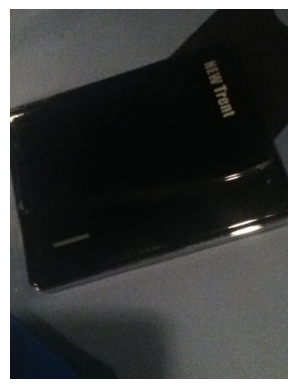

Answer: black

What is this?


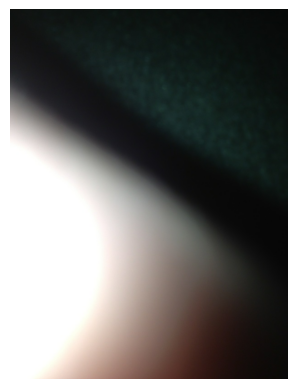

Answer: unsuitable

Has this oven gotten up to four hundred fifty degrees Fahrenheit yet?


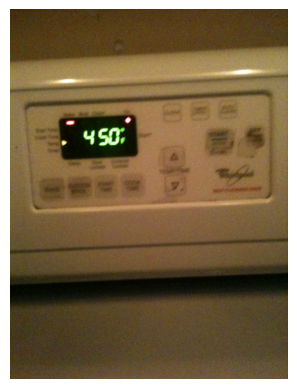

Answer: unsuitable

What is this?


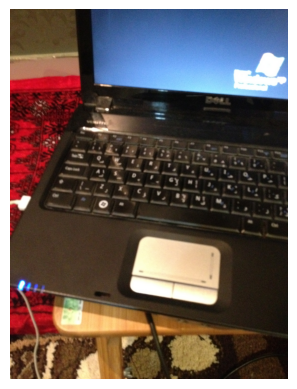

Answer: remote control

What is this?


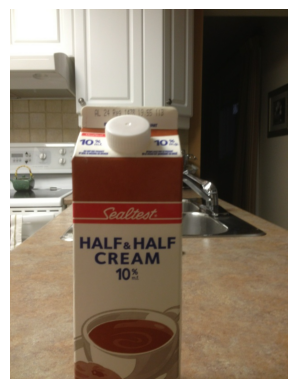

Answer: bottle



In [105]:
import matplotlib.pyplot as plt
from PIL import Image
import random
#choose random 5 images
random_integers = random.sample(range(51), 5)
for i in random_integers:
    ques=test_bonus.iloc[i]['question']
    print(ques)
    # Specify the image file path
    image_path = "/kaggle/input/vizwiz/test/test/"+str(test_bonus.iloc[i]['image'])

    # Open the image using PIL (Python Imaging Library)
    image = Image.open(image_path)

    # Display the image using Matplotlib
    plt.imshow(image)
    plt.axis('off')  
    plt.show()
    print("Answer:",answers[i])
    print()